<a href="https://colab.research.google.com/github/dynamodenis/Google-Deep-Learning-LLM-Models/blob/main/PreProcess/Google_Train_Tokenizer_gdm_lab_2_6_train_an_slm_with_your_bpe_tokenizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> <p><small><small>This Notebook is made available subject to the licence and terms set out in the <a href = "http://www.github.com/google-deepmind/ai-foundations">AI Research Foundations Github README file</a>.

![](https://storage.googleapis.com/dm-educational/assets/ai_foundations/GDM-Labs-banner-image-C2-white-bg.png)

# Lab: Train an SLM with Your BPE Tokenizer

<a href='https://colab.research.google.com/github/google-deepmind/ai-foundations/blob/master/course_2/gdm_lab_2_6_train_an_slm_with_your_bpe_tokenizer.ipynb' target='_parent'><img src='https://colab.research.google.com/assets/colab-badge.svg' alt='Open In Colab'/></a>

Train your byte pair encoding tokenizer on the Africa Galore dataset and use it to train a transformer-based language model.

25 minutes

## Overview

In this lab, you will apply the skills you have learned in this course and 01 Build Your Own Small Language Model. You will again train a small language model (SLM) on the Africa Galore dataset. This time, however, you will first learn the **merges** for a **byte pair encoding (BPE) subword tokenizer** and then use this tokenizer to prepare your data for training the model. Finally, you will use the **t-SNE dimensionality reduction** technique from the previous lab to visualize some of the token embeddings that your model has learned.

### What you will learn

By the end of this lab, you will understand:

* How you can apply the BPE algorithm to learn merges from a text dataset.
* How this tokenizer turns texts into subword units.
* How you can use the resulting tokenizer to prepare data for training a transformer language model.
* Which similarities an SLM captures in its token embeddings.

### Tasks

In this lab, you will:

* Load and inspect the **Africa Galore** dataset.
* Train a BPE encoder on the Africa Galore dataset.
* Encode and decode example words and sentences (including made-up words) to see how this tokenizer handles **out-of-vocabulary (OOV)** cases.
* Convert the tokenized corpus into **padded numerical index sequences** required for model training.
* Train the **transformer model** from the previous course on the dataset and observe how.
* Visualize the learned embeddings of some of the tokens using the **t-SNE algorithm**.

Note that you do not need to add any code to perform the activities in this notebook. All the code will run without making any modifications. For some activities, however, you may want to update parameters to see how they affect the behavior of your tokenizer and model.

If you are able to, we highly recommend running the code in this lab on a **Colab instance with a GPU**. See the section "How to use Google Colaboratory (Colab)" below for instructions on how to do this.



## How to use Google Colaboratory (Colab)

Google Colaboratory (also known as Google Colab) is a platform that allows you to run Python code in your browser. The code is written in **cells** that are executed on a remote server.

To run a cell, hover over a cell, and click on the `run` button to its left. The run button is the circle with the triangle (▶). Alternatively, you can also click on a cell and use the keyboard combination Ctrl+Return (or ⌘+Return if you are using a Mac).

To try this out, run the following cell. This should print today's day of the week below it.

In [ ]:
from datetime import datetime
print(f"Today is {datetime.today():%A}.")

Note that the *order in which you run the cells matters*. When you are working through a lab, make sure to always run *all* cells in order. Otherwise, the code might not work. If you take a break while working on a lab, Colab may disconnect you and in that case, you have to execute all cells again before  continuing your work. To make this easier, you can select the cell you are currently working on and then choose __Runtime → Run before__  from the menu above (or use the keyboard combination Ctrl/⌘ + F8). This will re-execute all cells before the current one.

### Using Colab with a GPU

A **GPU** is a special type of hardware that can significantly speed up some types of computations of machine learning models. Several of the activities in this lab will also run a lot faster if you run them on a GPU.

Follow these steps to run the activities in this lab on a GPU:

1.  In the top menu bar, click on **Runtime**.
2.  Select **Change runtime type** from the dropdown menu.
3.  In the pop-up window under **Hardware Accelerator**, select **GPU** (usually listed as `T4 GPU`).
5.  Click **Save**.

Your Colab session will now restart with GPU access.

Note that access to GPUs is limited and at times, you may not be able to run this lab on a GPU. All activities will still work but they will run slower and you will have to wait longer for some of the cells to finish running.


## Imports

In this lab, you will primarily work with the `ai_foundations` package. In the background, this implements methods for defining and training the SLM in Keras and visualizing the learned embeddings.

Run the following cell to import the required packages.

In [1]:
%%capture
# Install the custom package for this course.
!pip install "git+https://github.com/google-deepmind/ai-foundations.git@main"

from collections import Counter # For counting tokens in the BPE tokenizer.
import os # Used for setting Keras configuration variables.
import string # For accessing string constants.

# The following line provides configuration for Keras.
os.environ["KERAS_BACKEND"] = "jax"

import keras
import numpy as np # For working with vectors and matrices.
import pandas as pd # For loading the Africa Galore dataset.
import tqdm # For displaying progress bars.

from ai_foundations import training # For defining and training the SLM.
from ai_foundations import embeddings as emb # For visualizing embeddings.

## A complete implementation of the BPE tokenizer

The class `BPEWordTokenizer` below defines a complete implementation of a BPE tokenizer, including methods for training the tokenizer on a text dataset (a corpus) and translating texts between token IDs and string representations.  

This class primarily contains methods that you implemented yourself in the fourth lab of this course:

* `__init__`: The constructor. It builds the list of merges and the vocabulary if a dataset is specified.
- `encode`: Converts a text to a list of token IDs.
* `_split_text`: A helper method for `encode`. Splits a string into subword tokens using the learned list of merges.
- `decode`: Reconstructs a text from a list of token IDs.
* `_join_text`: A helper method for `decode`. Reconstructs text from BPE tokens.
* `_learn_bpe`: Learns merge rules from training text.
* `_get_pair_frequencies`: A helper method for `learn_bpe`. Returns the frequencies of all adjacent token pairs.
* `_merge_pairs_in_word`: A helper method for `_learn_bpe` and `_split_text`. Applies a merge to an individual word represented by a list of subword tokens.

Go through the implementation of `BPEWordTokenizer` to understand what each of these methods does. Then run the cell to define the `BPEWordTokenizer` class.

In [2]:
class BPEWordTokenizer:
    """
    A Byte Pair Encoding (BPE) based subword tokenizer.

    This class supports encoding and decoding text to subword tokens using BPE.
    It can learn merge rules from a corpus or be initialized with a pre-built
    vocabulary.

    Attributes:
        vocabulary: List of subword tokens including special tokens.
        vocabulary_size : Total number of tokens in vocabulary.
        token_to_index: Mapping from tokens to indices.
        index_to_token: Mapping from indices to tokens.
        pad_token_id: Index of the padding token.
        unknown_token_id: Index of the unknown token.
        tokenized_corpus: Cached tokenized corpus after BPE training.
    """

    UNKNOWN_TOKEN = "<UNK>"
    PAD_TOKEN = "<PAD>"
    END_WORD = "</w>"

    def __init__(
        self,
        texts: list[str] | str,
        vocabulary: list[str] | None = None,
        num_merges: int = 100,
    ):
        """Initializes the BPEWordTokenizer.

        If no vocabulary is specified, it extracts the unique tokens from the
        text corpus and learns the BPE merges.

        Args:
          texts: A list of strings or a string representing the text corpus.
          vocabulary: Optional list of strings with unique tokens.
          num_merges: Defines how many rounds of merges should be performed
            when learning the BPE merges.
        """

        # Normalize to list of strings.
        if isinstance(texts, str):
            texts = [texts]

        if vocabulary is None:
            # Learn BPE merges and derive vocabulary from tokenized corpus.
            self.merges, tokenized, vocabulary_set = self._learn_bpe(
                texts, num_merges
            )
            self.tokenized_corpus = tokenized

            # Ensure that basic alphanumeric characters are always included in
            # the vocabulary.
            required_chars = set(
                string.ascii_lowercase + string.ascii_uppercase + string.digits
            )

            vocabulary_set.update(required_chars)

            # Add special tokens to the vocabulary.
            self.vocabulary = (
                [self.PAD_TOKEN] + sorted(vocabulary_set) + [self.UNKNOWN_TOKEN]
            )

        else:
            self.vocabulary = vocabulary
            self.merges = []  # Skip merge logic when a vocabulary is provided.

        # Build mappings and set IDs of special tokens.
        self.vocabulary_size = len(self.vocabulary)
        self.token_to_index = {tok: i for i, tok in enumerate(self.vocabulary)}
        self.index_to_token = {i: tok for i, tok in enumerate(self.vocabulary)}
        self.pad_token_id = self.token_to_index[self.PAD_TOKEN]
        self.unknown_token_id = self.token_to_index[self.UNKNOWN_TOKEN]

    def _split_text(self, text: str) -> list[str]:
        """Split a string into subword tokens using learned BPE merges.

        Args:
          text: String to split into subword tokens.

        Returns:
          List of subword tokens that together form the original text.
        """
        tokens = []
        for word in text.strip().split():
            # Split the string into characters and add special END_WORD token.
            chars = list(word) + [self.END_WORD]

            # Merge individual characters according to learned BPE merges.
            for pair in self.merges:
                chars = self._merge_pairs_in_word(chars, pair)
            tokens.extend(chars)
        return tokens

    def join_text(self, tokens: list[str]) -> str:
        """Join subword tokens into full string, preserving word boundaries.

        Args:
          tokens: List of subword tokens to be joined.

        Returns:
          String obtained from joining the subword tokens.
        """
        words = []
        current_word = []
        for token in tokens:
            # Check whether token ends with a word boundary marker.
            if token.endswith(self.END_WORD):
                current_word.append(token.replace(self.END_WORD, ""))
                words.append("".join(current_word))
                current_word = []
            else:
                current_word.append(token)
        if current_word:
            words.append("".join(current_word))
        return " ".join(words).strip()

    def encode(self, text: str) -> list[int]:
        """
        Encode a string into list of token indices.

        Args:
            text: Input text.

        Returns:
            List of integers corresponding to tokens.
        """
        token_ids = []
        for token in self._split_text(text):
            token_id = self.token_to_index.get(token, self.unknown_token_id)
            token_ids.append(token_id)
        return token_ids

    def decode(self, token_ids: int | list[int]) -> str:
        """
        Decode list of token IDs back to original text.

        Args:
          token_ids: Single index or list of token IDs.

        Returns:
          Decoded text string.
        """
        # Covert to list if a single token index is specified.
        if isinstance(token_ids, int):
            token_ids = [token_ids]

        tokens = []
        for token_id in token_ids:
            tokens.append(
                self.index_to_token.get(
                    token_id,
                    self.UNKNOWN_TOKEN + self.END_WORD,
                )
            )
        return self.join_text(tokens)

    def _get_pair_frequencies(self, corpus: list[list[str]]) -> Counter[str]:
        """Count all adjacent token pairs in corpus.

        Args:
          corpus: A list of lists of strings representing subword tokens.

        Returns:
          Counter mapping adjacent pairs of subword tokens to their frequencies.
        """
        pairs = Counter()
        for word in corpus:
            for i in range(len(word) - 1):
                pair = (word[i], word[i + 1])
                # Increase the count by 1.
                pairs[pair] += 1
        return pairs

    def _merge_pairs_in_word(
        self, word: list[str], pair_to_merge: tuple[str, str]
    ) -> list[str]:
        """Merge all occurrences of a token pair inside a word.

        Args:
          tokens: A list of subword tokens representing one space separated
            word.
          pair_to_merge: A pair of two subword tokens that should be merged into
            one subword token.

        Returns:
          New list of subword tokens representing the word after applying the
            merge.
        """

        merged_symbol = pair_to_merge[0] + pair_to_merge[1]
        if pair_to_merge[0] not in word or pair_to_merge[1] not in word:
            return word
        i = 0
        new_word = []
        while i < len(word):
            if i < len(word) - 1 and (word[i], word[i + 1]) == pair_to_merge:
                new_word.append(merged_symbol)
                i += 2
            else:
                new_word.append(word[i])
                i += 1
        return new_word

    def _learn_bpe(
        self, corpus: list[str], num_merges: int
    ) -> tuple[list[tuple[str, str]], list[list[list[str]]], set[str]]:
        """
        Learn BPE merges from a corpus of texts.

        Args:
          corpus: List of input texts.
          num_merges: Number of merge operations to perform.

        Returns:
            merges: List of merges in order they are learned to be performed.
            tokenized_corpus: List of list of list of subword tokens where each
              paragraph in the corpus is tokenized as a list of list of
              subword tokens.
            vocabulary_set: Set of subword tokens after performing all merges.
        """
        # List of lists of lists to store tokenized text corpus.
        tokenized_corpus = []
        vocabulary = set([self.END_WORD])
        for paragraph in corpus:
            sentence_raw_tokens = []
            for word in paragraph.strip().split():
                # Split the word into characters and add word boundary marker.
                sentence_raw_tokens.append(list(word) + [self.END_WORD])
                vocabulary.update(list(word))
            tokenized_corpus.append(sentence_raw_tokens)

        merges = []
        for _ in (pbar := tqdm.tqdm(range(num_merges), unit="merges")):
            # Build a one-dimensional list of all tokens in the corpus.
            flat_corpus = []
            for tokenized_paragraph in tokenized_corpus:
                flat_corpus.extend(tokenized_paragraph)

            # Find the most frequent pair of adjacent tokens.
            pair_freqs = self._get_pair_frequencies(flat_corpus)
            if not pair_freqs:
                break
            most_freq_pair, freq = pair_freqs.most_common(1)[0]
            if freq < 1:
                break
            merges.append(most_freq_pair)

            # Apply merge to each token in each paragraph.
            new_tokenized_corpus = []
            for para_tokens in tokenized_corpus:
                new_para_tokens = []
                for word_tokens in para_tokens:
                    new_para_tokens.append(
                        self._merge_pairs_in_word(word_tokens, most_freq_pair)
                    )
                new_tokenized_corpus.append(new_para_tokens)
            tokenized_corpus = new_tokenized_corpus
            vocabulary.add(most_freq_pair[0] + most_freq_pair[1])
            pbar.set_postfix(vocabulary_size=f"{len(vocabulary):,}")

        return merges, tokenized_corpus, vocabulary

## Train the BPE tokenizer

You will train the BPE tokenizer on the [Africa Galore](https://storage.googleapis.com/dm-educational/assets/ai_foundations/africa_galore.json) dataset.

As you have learned in this course, the first step would usually be to preprocess the dataset. However, as the Africa Galore dataset was synthetically generated for this course, it does not require any additional preprocessing and you can skip this step.

Run the following cell to load the dataset.

In [3]:
africa_galore = pd.read_json(
    "https://storage.googleapis.com/dm-educational/assets/ai_foundations/africa_galore.json"
)
dataset = africa_galore["description"].values
print("Loaded dataset with", dataset.shape[0], "paragraphs.")

Loaded dataset with 232 paragraphs.


You will now use the `BPEWordTokenizer` class to learn merges from your dataset.

For this dataset, performing around 3,000 merges results in tokens for many common words and subwords for common prefixes and suffixes. However, this is just a recommendation and you can experiment with increasing or decreasing the number of merges. Before you move on to the next activities, however, re-run the cell with 3,000 merges. Otherwise, some of the activities in later parts of this lab may not work.

Run the following cell to train your tokenizer. As it learns to perform merges, observe how the size of the vocabulary increases.

In [4]:
num_merges = 3000

tokenizer = BPEWordTokenizer(dataset, num_merges=num_merges)
print(f"\n\nFinal tokenizer vocabulary size: {tokenizer.vocabulary_size:,}\n")

100%|██████████| 3000/3000 [00:58<00:00, 51.06merges/s, vocabulary_size=3,078]




Final tokenizer vocabulary size: 3,081



Note that the final vocabulary size is slightly higher than the vocabulary size after the last merge. This is because  the constructor (the `__init__` method) also adds special tokens for padding and the unknown token to vocabulary and makes sure that all letters, numbers and common symbols are included in the vocabulary. This means that several tokens that do not appear in the corpus are also added to the vocabulary after the merges have been learned.

### Observe the behavior of your tokenizer

To get a sense of what kind of tokens the vocabulary of your tokenizer includes and what merges it has learned, examine the tokenization of the first 20 words in the Africa Galore dataset.

In [5]:
africa_galore_tokenized = tokenizer.tokenized_corpus
for tokens in africa_galore_tokenized[0][:20]:
    print(" ".join(tokens))

The</w>
Lago s</w>
air</w>
was</w>
thick</w>
with</w>
humid ity,</w>
but</w>
the</w>
energy</w>
in</w>
the</w>
cl ub </w>
was</w>
electr ic.</w>
The</w>
band</w>
la un ched</w>
into</w>
a</w>


Each line in the output above shows a word from the original Africa Galore text, which has been broken down into its subword tokens by the BPEWordTokenizer. Notice how a word like "launched" is broken down into the smaller, more common subword tokens it learned during training, such as "la", "un", and "ched`</w>`", where the `</w>` marks the end of the word. This is the strength of the BPE algorithm. Instead of preserving whole words, it represents them as sequences of frequently occurring pieces. This approach allows the model to understand new or rare words by breaking them down into familiar parts, effectively solving the out-of-vocabulary problem while keeping the vocabulary size manageable.

A key design choice when training a BPE tokenizer is to decide how many merges to perform. The right number depends on your dataset, your language, and your final goal. Consequently, finding the optimal vocabulary size is often a process of experimenting to see what gives your model the best performance.



### Tokenization of unknown words

To illustrate how the BPE tokenizer handles unknown words, tokenize the phrase "A Zimbabwian dish 😋." which contains "Zimbabwian", a word that does not appear in the Africa Galore corpus, and the emoji "😋".


In [6]:
madeup_tokens = tokenizer.encode("A Zimbabwian dish 😋.")

print(f"Decoded sentence from tokens: {tokenizer.decode(madeup_tokens)}")
for token in madeup_tokens:
    decoded_token = tokenizer.decode(token)
    print(f"Token {token}:\t{decoded_token}")

Decoded sentence from tokens: A Zimbabwian dish <UNK>.
Token 63:	A
Token 388:	Zimbab
Token 3003:	wi
Token 500:	an
Token 1026:	dish
Token 3080:	<UNK>
Token 35:	.


As you can see, instead of mapping "Zimbabwian" to the uninformative `<UNK>` token, the tokenizer splits this into the tokens "Zimbab", "wi", "an". If the model has been trained on the word "Zimbabwe" tokenized into "Zimbab" and "we", it will likely be able to relate "Zimbabwian" to "Zimbabwe".

As the Africa Galore dataset does not contain any emojis and you did not manually add any Unicode characters to the vocabulary of the tokenizer, the emoji "😋" is mapped to the `<UNK>` token.

## Prepare the dataset for training the model

With your tokenizer in place, you can now prepare the dataset for training your SLM. Recall that the data needs to be converted to token IDs so that it can serve as input for a transformer language model.

As a first step, run the following cell to use your BPE tokenizer to convert the training dataset into sequences of token IDs.

In [7]:
encoded_tokens = []
for paragraph in tqdm.tqdm(dataset, unit="paragraphs"):
    encoded_tokens.append(tokenizer.encode(paragraph))

100%|██████████| 232/232 [00:10<00:00, 22.05paragraphs/s]


Next, pad all sequences. Recall that the input to a transformer model has to be a sequence of a specific length. By padding shorter sequences and truncating longer ones, you can make sure that all sequences have the length `max_length`.

Run the following cell to truncate and pad sequences using the Keras function `keras.preprocessing.sequence.pad_sequences`.

In [8]:
max_length = 300
padded_sequences = keras.preprocessing.sequence.pad_sequences(
        encoded_tokens,
        maxlen=max_length,
        padding="post",
        truncating="post",
        value=tokenizer.pad_token_id,
    )

Finally, prepare the input and the targets for the transformer model. As you are training the model on the next-word prediction task, the target for each token is the next token in the sequence.

Run the following cell to create the list of input sequences and the list of target sequences by shifting the input sequence by one token.

In [9]:
# Prepare input and target for the transformer model.
# For each example, extract all tokens except the last one.
input_sequences = padded_sequences[:, :-1]
# For each example, extract all tokens except the first one.
target_sequences = padded_sequences[:, 1:]

max_length = input_sequences.shape[1]

## Train the model

You can now train the model. The following cell initializes a model and then trains it for 100 epochs following the same process you followed in 01 Build Your Own Small Language Model. Every 10 epochs, it prints a generation starting with "Jide" that lets you monitor how the generations change over time.





In [10]:
# Set a seed for reproducability.
keras.utils.set_random_seed(3112)

model = training.create_model(
    max_length=max_length,
    vocabulary_size=tokenizer.vocabulary_size,
    learning_rate=8e-5
)

prompt = "Jide"
prompt_ids = tokenizer.encode(prompt)
text_gen_callback = training.TextGenerator(
    max_tokens=11, start_tokens=prompt_ids, tokenizer=tokenizer, print_every=10
)

num_epochs = 100
# verbose=2: Instructs the model.fit method to print one line per
# epoch so you can observe loss decreasing and the generated texts improving.
history = model.fit(
    x=input_sequences,
    y=target_sequences,
    verbose=2,
    epochs=num_epochs,
    batch_size=2,
    callbacks=[text_gen_callback]
)

Epoch 1/100
116/116 - 7s - 64ms/step - loss: 7.5291
Epoch 2/100
116/116 - 3s - 25ms/step - loss: 6.9468
Epoch 3/100
116/116 - 0s - 3ms/step - loss: 6.8174
Epoch 4/100
116/116 - 0s - 3ms/step - loss: 6.7028
Epoch 5/100
116/116 - 0s - 3ms/step - loss: 6.5011
Epoch 6/100
116/116 - 0s - 3ms/step - loss: 6.2900
Epoch 7/100
116/116 - 0s - 3ms/step - loss: 6.0652
Epoch 8/100
116/116 - 0s - 3ms/step - loss: 5.8467
Epoch 9/100
116/116 - 0s - 3ms/step - loss: 5.6366
Epoch 10/100
Generated text:
 Jide Mali, was hungry so he went looking for strlooking for 

116/116 - 3s - 22ms/step - loss: 5.4473
Epoch 11/100
116/116 - 0s - 3ms/step - loss: 5.2405
Epoch 12/100
116/116 - 0s - 3ms/step - loss: 5.0514
Epoch 13/100
116/116 - 0s - 3ms/step - loss: 4.8931
Epoch 14/100
116/116 - 0s - 3ms/step - loss: 4.7228
Epoch 15/100
116/116 - 0s - 3ms/step - loss: 4.5757
Epoch 16/100
116/116 - 0s - 3ms/step - loss: 4.4127
Epoch 17/100
116/116 - 0s - 3ms/step - loss: 4.2620
Epoch 18/100
116/116 - 0s - 3ms/step - loss

#### What did you observe?

After earlier epochs, the model likely generated sequences that include words that are just random strings of characters. This is because the model now samples subword tokens instead of entire words. Early in the training process, the model has not yet learned the correct patterns for combining subword tokens. As a result, it combines them randomly, often forming strings that do not correspond to actual words.

As the model learns better parameters during training, it is able to successfully combine subword tokens to form actual, recognizable words. This is a necessary step for the eventual goal of generating fluent sentences.

## Visualize the embeddings

Your small language model learns token embeddings just like the Gemma model. After you have trained your model, you are similarly able to visualize them.

The following cell extracts the embeddings from your model and then selects several tokens corresponding to different word categories (food and drink related words, prepositions, adjectives, and country names). It then uses t-SNE to project the embeddings to a 2-dimensional space, so that they can be plotted.

Run the following cell to generate the t-SNE plot and investigate which clusters emerge in this plot.

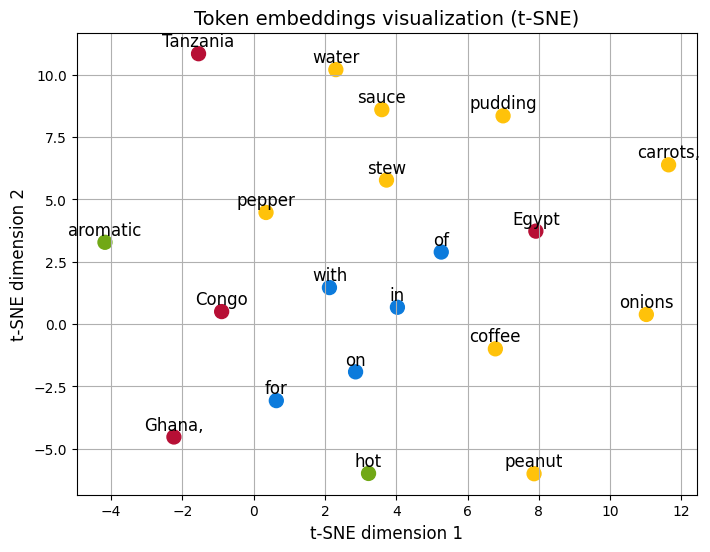

In [11]:
# Extract all embeddings from your model as a matrix.
embeddings = model.trainable_weights[0].value

# Define token categories.
food_and_drink = [
    "water",
    "coffee",
    "onions",
    "peanut",
    "pepper",
    "pudding",
    "sauce",
    "stew",
    "carrots,"
]
prepositions = ["on", "in", "with", "for", "of"]
adjectives = ["aromatic", "hot"]
countries = ["Egypt", "Congo", "Ghana,", "Tanzania"]

# Define list of tokens and map them to categories for coloring them.
tokens = food_and_drink + prepositions + adjectives + countries
categories = (
    [0] * len(food_and_drink)
    + [1] * len(prepositions)
    + [2] * len(adjectives)
    + [3] * len(countries)
)

# Convert tokens into token IDs.
token_ids = []
for token in tokens:
    token_ids.extend(tokenizer.encode(token))

# Check that each token is represented as a single token in the tokenizer.
assert len(token_ids) == len(tokens)

# Extract embeddings for the set of tokens of interest.
embeddings_subset = embeddings[token_ids, :]

# Generate t-SNE plot with embeddings from your model.
emb.plot_embeddings_tsne(embeddings_subset, tokens, categories)

#### What did you observe?

In the plot above, you may have observed that the prepositions (in blue) form a relatively tight cluster. Most of the other terms are likely quite close in space as well but they may not form as tight clusters.

This is because the model that you trained was trained on a very small dataset and some of these tokens appear in very few contexts. Therefore, the model may have not had very much information to learn the meaning of some of these words. On the other hand, for frequent function words, like prepositions, even such a small dataset provides a lot of information. This means the model learns that they have similar meanings and serve similar functions in sentences.

## Summary

In this lab, you **trained a small language model** from scratch by first creating and training a custom **byte-pair encoding (BPE) tokenizer** on the Africa Galore dataset. You used this tokenizer to convert text into **subword tokens** and prepare the data for training. After training the transformer model, you observed how its ability to generate coherent text improved as it learned to combine these subword tokens into meaningful words and sentences. Finally, by visualizing the model's learned **embeddings** with t-SNE, you explored how it began to organize tokens into meaningful clusters. You observed how it grouped words with similar functions (e.g., prepositions) together in the embedding space.